In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [3]:
CATEGORIES = ['Sugarbeet', 'Charlock', 'Stop', 'Priority']

In [10]:
device = torch.device('cpu')
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, len(CATEGORIES))

model = model.to(device)

model_path = '/content/drive/MyDrive/Colab Notebooks/classify_data_80-20/classification_model_v2e2.pth'
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model = model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
import os
import glob
from PIL import Image

# Directory containing the images
image_dir = '/content/drive/MyDrive/Colab Notebooks/classify_data_80-20/predict/'

# Subfolders to search for files
subfolders = ['Charlock', 'Priority', 'Stop', 'Sugarbeet']

# File extensions of the images
image_extensions = ['*.jpg']  # Add more extensions if necessary

# Find image files using glob
image_files = []
for folder in subfolders:
    folder_path = os.path.join(image_dir, folder)
    for extension in image_extensions:
        image_files.extend(glob.glob(f"{folder_path}/{extension}"))

# Load images and build image_list
image_list = []
label_list = []

# Convert labels to numerical values
category_mapping = {
    'Sugarbeet': 0,
    'Charlock': 1,
    'Stop': 2,
    'Priority': 3
}

for image_file in image_files:
    image = Image.open(image_file)
    image_list.append(image)

    # Extract category from image file path
    category = os.path.basename(os.path.dirname(image_file))

    # Map category to numerical value
    label = category_mapping.get(category, -1)  # Default to -1 if category is not found
    label_list.append(label)

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Preprocess the images
processed_images = torch.stack([preprocess(image) for image in image_list])
labels = torch.tensor(label_list)

In [11]:
with torch.no_grad():
    processed_images = processed_images.to(device)
    outputs = model(processed_images)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    predicted_classes = torch.argmax(probabilities, dim=1)

In [12]:
# Create the confusion matrix
cm = confusion_matrix(labels, predicted_classes)

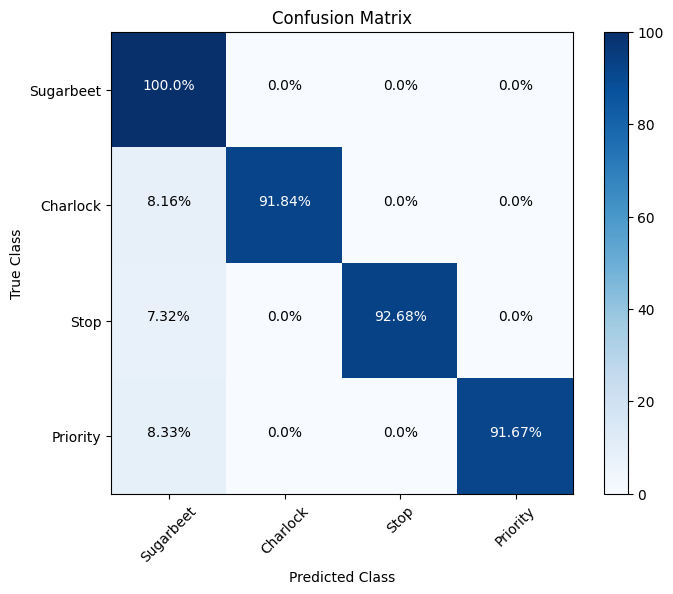

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the percentage correct for each class
row_sums = np.sum(cm, axis=1)
cm_percent = np.round((cm / row_sums[:, np.newaxis]) * 100, decimals=2)

# Plot the confusion matrix with percentage correct
plt.figure(figsize=(8, 6))
plt.imshow(cm_percent, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add percentage correct as text annotations
thresh = cm_percent.max() / 2.
for i in range(cm_percent.shape[0]):
    for j in range(cm_percent.shape[1]):
        plt.text(j, i, f'{cm_percent[i, j]}%',
                 horizontalalignment="center",
                 color="white" if cm_percent[i, j] > thresh else "black")

# Set axis labels and tick marks
tick_marks = np.arange(len(CATEGORIES))
plt.xticks(tick_marks, CATEGORIES, rotation=45)
plt.yticks(tick_marks, CATEGORIES)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

plt.show()

In [14]:
# Calculate overall accuracy
total_correct = np.trace(cm)
total_samples = np.sum(cm)
overall_accuracy = total_correct / total_samples * 100

print(f"Overall Accuracy: {overall_accuracy:.2f}%")

Overall Accuracy: 93.33%
